# Import Modules

In [1]:
# basic
import os
import gdal
import shutil
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt

# main
from PySatellite.SplittedImage import SplittedImage
from PySatellite.SatelliteIO import get_geo_info, get_nparray, get_extend, write_output_tif, clip_tif_by_shp, tif_composition, refine_resolution, rasterize_layer, polygonize_layer, raster_pixel_to_polygon, get_testing_fp
from PySatellite.Algorithm import kmeans
from PySatellite.Normalizer import Normalizer
from PySatellite.CRS import transfer_npidx_to_coord, transfer_coord_to_npidx, transfer_npidx_to_coord_polygon

satellite_tif_path = get_testing_fp('satellite_tif')
satellite_tif_clipper_path = get_testing_fp('satellite_tif_clipper')
satellite_tif_kmeans_path = get_testing_fp('satellite_tif_kmeans')
rasterized_image_path = get_testing_fp('rasterized_image')

output_dir = "output"
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)



# SatelliteIO


## read the file

cols, rows, bands:  (512, 512, 4)
geo_transform:  (328530.0, 10.0, 0.0, 2750790.0, 0.0, -10.0)
projection:  PROJCS["TAIWAN",GEOGCS["GCS_NOT_SPECIFIED",DATUM["USGRS67",SPHEROID["GRS67",6378160,298.2471674]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",120.9995190069077],PARAMETER["scale_factor",0.9999],PARAMETER["false_easting",250000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
dtype_gdal:  5
no_data_value:  -99.0


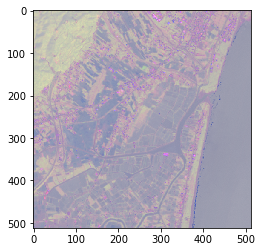

In [2]:
cols, rows, bands, geo_transform, projection, dtype_gdal, no_data_value = get_geo_info(satellite_tif_path)
X = get_nparray(satellite_tif_path)
print("cols, rows, bands: ", (cols, rows, bands))
print("geo_transform: ", geo_transform)
print("projection: ", projection)
print("dtype_gdal: ", dtype_gdal)
print("no_data_value: ", no_data_value)
plt.imshow(X)
plt.show()

## clip_tif_by_shp


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


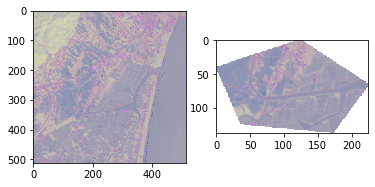

In [3]:
clipped_image_fp = os.path.join(output_dir, 'clipped_image.tif')
clip_tif_by_shp(satellite_tif_path, satellite_tif_clipper_path, clipped_image_fp)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(get_nparray(satellite_tif_path))
ax2.imshow(get_nparray(clipped_image_fp))
plt.show()

## tif_composition


In [4]:
crs_tif_fp = satellite_tif_path
tif_to_be_composited_fps = [satellite_tif_path, satellite_tif_kmeans_path]
composited_image_fp = os.path.join(output_dir, 'composited_image.tif')
tif_composition(crs_tif_fp, tif_to_be_composited_fps, composited_image_fp)
print("original bands:")
for tif_fp in tif_to_be_composited_fps:
    cols, rows, bands, geo_transform, projection, dtype_gdal, no_data_value = get_geo_info(tif_fp)
    print(os.path.split(tif_fp)[-1]+": ", bands)
cols, rows, bands, geo_transform, projection, dtype_gdal, no_data_value = get_geo_info(composited_image_fp)
print("composited_image bands: ", bands)

original bands:
satellite_tif.tif:  4
satellite_tif_kmeans.tif:  1
composited_image bands:  5


## refine_resolution


In [5]:
resolution_refined_image_fp = os.path.join(output_dir, 'resolution_refined_image.tif')
refine_resolution(satellite_tif_path, resolution_refined_image_fp, dst_resolution=5)
print("original shape: ", get_nparray(satellite_tif_path).shape)
print("transformed shape: ", get_nparray(resolution_refined_image_fp).shape)


original shape:  (512, 512, 4)
transformed shape:  (1024, 1024, 4)


## write_output_tif


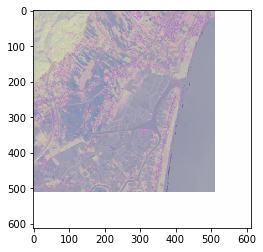

In [6]:
X_fp = satellite_tif_path
X_arr = get_nparray(X_fp)
cols, rows, bands, geo_transform, projection, dtype_gdal, no_data_value = get_geo_info(X_fp)
padded_image_arr = np.pad(X_arr, ((0,100), (0,100), (0,0)), mode='constant', constant_values=1)
padded_image_fp = os.path.join(output_dir, 'padded_image.tif')
write_output_tif(padded_image_arr, padded_image_fp, bands, cols+100, rows+100, geo_transform, projection)
plt.imshow(get_nparray(padded_image_fp))
plt.show()

## rasterize_layer


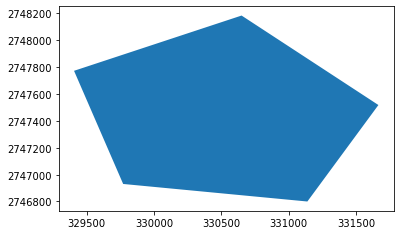

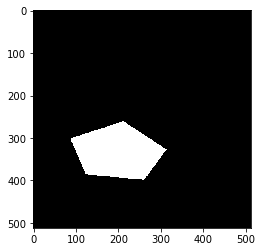

In [7]:
src_shp_path = satellite_tif_clipper_path
dst_tif_path = os.path.join(output_dir, 'rasterized_image.tif')
ref_tif_path = satellite_tif_path
rasterize_layer(src_shp_path, dst_tif_path, ref_tif_path)

df = gpd.read_file(src_shp_path)
df.plot()
plt.show()

plt.imshow(get_nparray(dst_tif_path)[:,:,0],cmap='gray')
plt.show()

## polygonize_layer


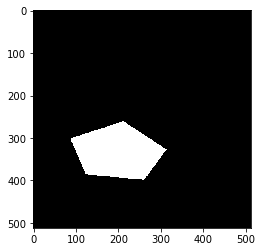

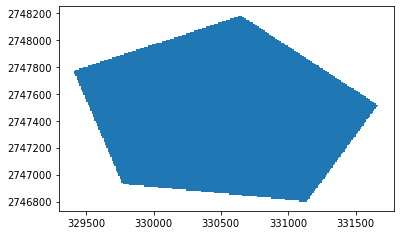

In [8]:
src_tif_path = rasterized_image_path
dst_shp_path = os.path.join(output_dir, 'polygonized_layer.shp')
polygonize_layer(src_tif_path, dst_shp_path)

plt.imshow(get_nparray(src_tif_path)[:,:,0],cmap='gray')
plt.show()
df_shp = gpd.read_file(dst_shp_path)
df_shp.plot()
plt.show()


## raster_pixel_to_polygon


In [10]:
src_tif_path = rasterized_image_path
dst_shp_path = os.path.join(output_dir, 'raster_pixel_to_polygon.shp')
raster_pixel_to_polygon(src_tif_path, dst_shp_path, all_bands_as_feature=True, crs={'init' :'epsg:3826'})
df_shp = gpd.read_file(dst_shp_path)
print("get_nparray(src_tif_path).shape: ", get_nparray(src_tif_path).shape)
print("np.product(get_nparray(src_tif_path).shape): ", np.product(get_nparray(src_tif_path).shape))
print("len(df_shp): ", len(df_shp))

get_nparray(src_tif_path).shape:  (512, 512, 1)
np.product(get_nparray(src_tif_path).shape):  262144
len(df_shp):  262144


# CRS

## transfer_npidx_to_coord (get the left top coord for the indexed pixel)


geo_transform:  (328530.0, 10.0, 0.0, 2750790.0, 0.0, -10.0)


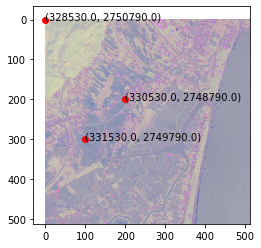

In [9]:
cols, rows, bands, geo_transform, projection, dtype_gdal, no_data_value = get_geo_info(satellite_tif_path)
npidx000000, npidx200200, npidx100300 = (00, 0), (200, 200), (100, 300)
coord000000, coord200200, coord100300 = transfer_npidx_to_coord(npidx000000, geo_transform), transfer_npidx_to_coord(npidx200200, geo_transform), transfer_npidx_to_coord(npidx100300, geo_transform)
print("geo_transform: ", geo_transform)
plt.imshow(get_nparray(satellite_tif_path))
plt.scatter(*npidx000000,color='r');plt.scatter(*npidx200200,color='r');plt.scatter(*npidx100300,color='r')
plt.text(*npidx000000, str(coord000000));plt.text(*npidx200200, str(coord200200));plt.text(*npidx100300, str(coord100300))
plt.show()

## transfer_coord_to_npidx (get the pixel index for the coord, coord in which pixel)


In [10]:
cols, rows, bands, geo_transform, projection, dtype_gdal, no_data_value = get_geo_info(satellite_tif_path)
npidx100300 = (1,3)
coord001003 = transfer_npidx_to_coord(npidx100300, geo_transform)
npidx001003 = transfer_coord_to_npidx(coord001003, geo_transform)
print("original point:")
print("npidx001003: ", npidx001003)

coord = (coord001003[0]+9, coord001003[1]-9)
npidx = transfer_coord_to_npidx(coord, geo_transform)
print("resolution is 10 meter, add 9 will be in the same cell")
print("npidx000004: ", npidx)

coord = (coord001003[0]+11, coord001003[1]-11)
npidx = transfer_coord_to_npidx(coord, geo_transform)
print("resolution is 10 meter, add 11 will be in the next cell")
print("npidx000004: ", npidx)

original point:
npidx001003:  (1, 3)
resolution is 10 meter, add 9 will be in the same cell
npidx000004:  (1, 3)
resolution is 10 meter, add 11 will be in the next cell
npidx000004:  (2, 4)


## transfer_npidx_to_coord_polygon


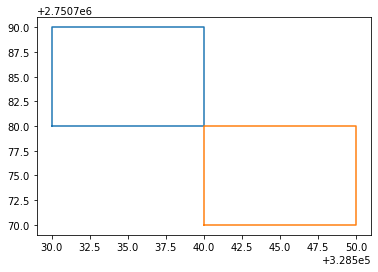

In [11]:
cols, rows, bands, geo_transform, projection, dtype_gdal, no_data_value = get_geo_info(satellite_tif_path)
npidx00, npidx11 = (0,0), (1,1)
polygon00, polygon11 = transfer_npidx_to_coord_polygon(npidx00, geo_transform), transfer_npidx_to_coord_polygon(npidx11, geo_transform)
(x00,y00), (x11,y11) = polygon00.exterior.xy, polygon11.exterior.xy
plt.plot(x00,y00)
plt.plot(x11,y11)
plt.show()


# Normalizer

## Normalizer

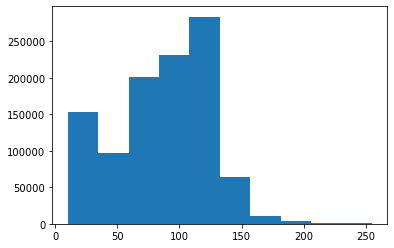

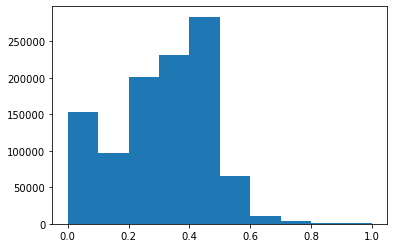

In [12]:
cols, rows, bands, geo_transform, projection, dtype_gdal, no_data_value = get_geo_info(satellite_tif_path)
X = get_nparray(satellite_tif_path)
plt.hist(X.flatten())
plt.show()

X_norm = Normalizer().fit_transform(X)
plt.hist(X_norm.flatten())
plt.show()



## Algorithm


## kmeans


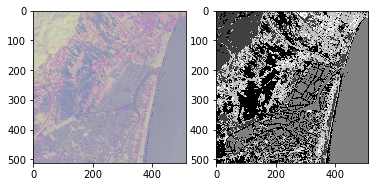

In [25]:
X_fp = satellite_tif_path
X_arr = get_nparray(X_fp)
cols, rows, bands, geo_transform, projection, dtype_gdal, no_data_value = get_geo_info(X_fp)
kmeans_arr = kmeans(X_arr, n_clusters=5, no_data_value=0)
kmeans_fp = os.path.join(output_dir, "X_kmeans.tif")
bands = 1
write_output_tif(kmeans_arr, kmeans_fp, bands, cols, rows, geo_transform, projection)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(get_nparray(X_fp))
ax2.imshow(get_nparray(kmeans_fp)[:,:,0], cmap='gray')
plt.show()


# SplittedImage

## create splitted_image object


In [3]:
cols, rows, bands, geo_transform, projection, dtype_gdal, no_data_value = get_geo_info(satellite_tif_path)
X = get_nparray(satellite_tif_path)
box_size = 40 # window_size_h = window_size_w = step_size_h = step_size_w = 256
splitted_image = SplittedImage(X, box_size, geo_transform, projection)
print("splitted_image.shape", splitted_image.shape)
print("splitted_image.get_splitted_images().shape: ", splitted_image.get_splitted_images().shape)



splitted_image.shape (13, 13)
splitted_image.get_splitted_images().shape:  (169, 40, 40, 4)


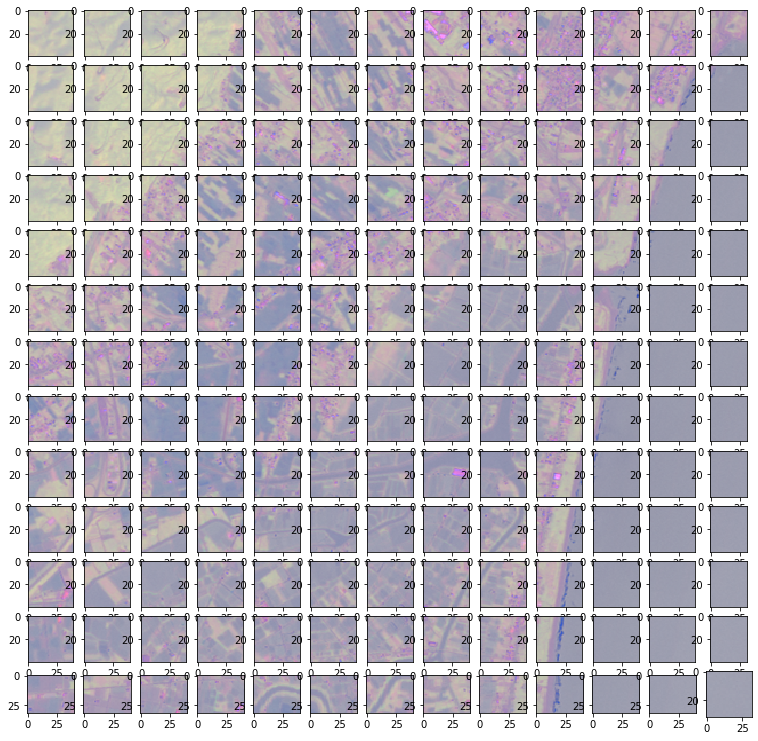

In [4]:
fig, axes = plt.subplots(*splitted_image.shape, figsize=splitted_image.shape)
for i in range(splitted_image.shape[0]):
    for j in range(splitted_image.shape[1]):
        x = splitted_image[i,j]
        axes[i][j].imshow(x)
        
plt.show()
    

## padded image for splitting


padded_image.shape:  (520, 520, 4)


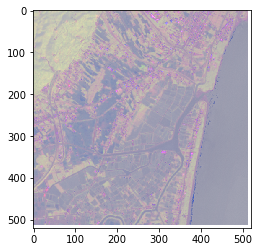

In [5]:
padded_image = splitted_image.padded_image 
print("padded_image.shape: ", padded_image.shape)
plt.imshow(padded_image)
plt.show()



## sliceing


sliced_splittted_image.shape:  (200, 200, 4)


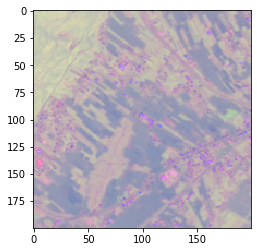

sliced_splittted_image.shape:  (400, 400, 4)


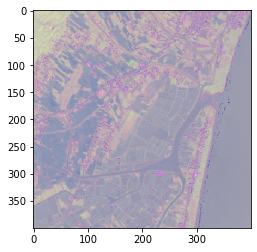

In [6]:
sliced_splittted_image = splitted_image[1:5, 2:6]
print("sliced_splittted_image.shape: ", sliced_splittted_image.shape)
plt.imshow(sliced_splittted_image)
plt.show()

sliced_splittted_image = splitted_image[1:10, 2:11]
print("sliced_splittted_image.shape: ", sliced_splittted_image.shape)
plt.imshow(sliced_splittted_image)
plt.show()

## get geo_attribute as shp for each splitted image


In [7]:
df_attribute = splitted_image.get_geo_attribute()
df_attribute.head()


,idx,idx_h,idx_w,geometry
0,0,0,0,"POLYGON ((328530 2750790, 328930 2750790, 3289..."
1,1,0,1,"POLYGON ((328530 2750390, 328930 2750390, 3289..."
2,2,0,2,"POLYGON ((328530 2749990, 328930 2749990, 3289..."
3,3,0,3,"POLYGON ((328530 2749590, 328930 2749590, 3289..."
4,4,0,4,"POLYGON ((328530 2749190, 328930 2749190, 3289..."


## wrtie splitted_image as files


len(os.listdir(splitted_images_dir)):  169


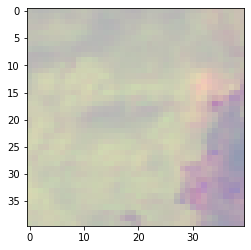

In [18]:
splitted_images_dir = os.path.join(output_dir, "splitted_images")
if not os.path.isdir(splitted_images_dir): 
    os.mkdir(splitted_images_dir)
splitted_image.write_splitted_images(splitted_images_dir, 'splitted_images')

print("len(os.listdir(splitted_images_dir)): ", len(os.listdir(splitted_images_dir)))
plt.imshow(get_nparray(os.path.join(splitted_images_dir, os.listdir(splitted_images_dir)[3])))
plt.show()


## write_combined_tif


X_pred.shape:  (36, 101, 101)


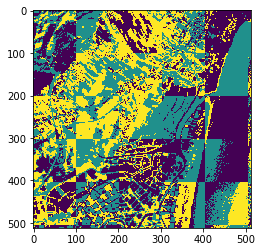

In [19]:
box_size = 101
splitted_image = SplittedImage(X, box_size, geo_transform, projection)
X_pred = splitted_image.get_splitted_images()
X_pred = np.array([kmeans(x, 3) for x in X_pred])
print("X_pred.shape: ", X_pred.shape)
combined_pred_fp = os.path.join(output_dir, "combined.tif")
splitted_image.write_combined_tif(X_pred, combined_pred_fp, gdal.GDT_Int16)
plt.imshow(get_nparray(combined_pred_fp)[:, :, 0])
plt.show()
